In [7]:
from utils import get_args
import os
import pandas as pd


args = get_args('config.yaml')
train_df = pd.read_csv(os.path.join(args.data.path, args.data.dataset, 'train.data'), compression='gzip')
if args.training.limit_train_size is not None:
    # truncate to first instances because data indices have to be maintained to use the cache
    train_df = train_df[:args.training.limit_train_size]

In [8]:
import pickle as pkl
def get_cache(cache_dir):
    instances = []
    files = os.listdir(cache_dir)
    for file in files:
        with open(os.path.join(cache_dir, file), 'rb') as f:
            instance = pkl.load(f)
        key = next(iter(instance.keys()))
        instance = instance[key]
        instances.append({'instance': key, 'length': len(next(iter(instance.values())))})
        instances[-1].update({
            k: set().union(*v) if isinstance(v[0], set) else set(v).difference({None})
            for k, v in instance.items() if len(v) > 0})
    return pd.DataFrame(instances)
cache_info = get_cache(args.env.cache_path)

In [9]:
cache_info

,instance,length,differential diagnoses,risk prediction,presenting complaint,differentials from complaint,confident diagnoses,matched confident diagnoses
0,0,5,"{left ventricular hypertrophy, ds 50 x3, pfo, ...","{coarctation of the aorta, cardiac disease, pf...",{},{},"{sats, pfo, aortic stenosis, shunting, congeni...","{aortic stenosis., congenital heart disease}"
1,1,13,"{peritoneal infection, atrioventricular block,...","{heart disease, heart attack, breast cancer, g...","{syncope, gi bleed, gib}","{cardiac arrest, gi bleed from a foreign body,...",{no evidence of malignancy},{}
2,10,20,"{left ventricular tamponade, myocardial infarc...","{left ventricular tamponade, myocardial infarc...","{cp, sinus tachycardia, intense substernal che...","{spondylolisthesis, sinus bradycardia, sinus t...","{left ventricular tamponade, anterolateral inf...","{aortic valve disease., aortic stenosis., hear..."
3,1000,4,"{sepsis, testicular torsion, right hydrocele}","{sepsis, gbs infection, testicular torsion}",{term male infant now 7 hours of life with inc...,"{scrotal hematoma, bacterial vaginosis, bacter...",{testicular torsion},{}
4,1001,28,"{d c d 2 fen, bronchiolitis, small for gestati...","{apnea, cardiac arrest, blood clotting disorde...","{uncoordinated suck swallow and desaturations,...","{acute respiratory distress syndrome, pulmonar...","{bronchitis, aga, immature breathing pattern, ...",{bronchitis}
...,...,...,...,...,...,...,...,...
2324,7311,34,"{clip number radiology 18953, l5 s1 spondyloli...","{spinal abscess, cardiac arrest, venous thromb...","{fever, gluteus decubitus ulcer extending to t...","{mrsa, bacterial infection viral infection, he...","{mrsa, bacteremia, lumbar spondylolisthesis, r...","{pneumonia, aortic dissection, osteomyelitis}"
2325,7312,27,"{acute encephalopathy, atrioventricular block,...","{head trauma, ventricular arrhythmias, deliriu...","{epilepsy now in a stupor, status post seizure...","{acute encephalopathy, stroke, epilepsy, encep...","{heart rhythm, epilepsy}",{epilepsy}
2326,7313,106,"{atrioventricular block, acute on chronic syst...","{heart attack, atrioventricular block, bronchi...","{hypotension, pulmonary hypertension, shortnes...","{heart disease, pulmonary tuberculosis, pulmon...","{atrioventricular block, hepatitis b, acute si...","{atrioventricular block, chronic obstructive p..."
2327,8,16,"{afib, acute respiratory distress syndrome, co...","{afib, heart disease, clotting disorders, 1 23...",{},{},"{rheumatic heart disease, 1 23 mr, pleural eff...","{chronic rheumatic heart disease, mitral valve..."


<Axes: xlabel='length', ylabel='Count'>

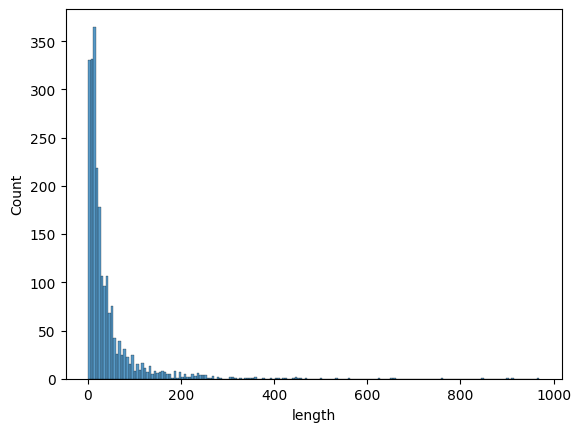

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=cache_info, x='length')

In [22]:
from collections import Counter
from functools import cache
import numpy as np
def get_counts(cache_info):
    counters = {c: Counter() for c in cache_info.columns if c not in ['instance', 'length']}
    for i, row in cache_info.iterrows():
        for name, counter in counters.items():
            for x in row[name]:
                counter[x] += 1
    return counters
def plot_counts(cache_info, counters):
    for name, counter in counters.items():
        print(name)
        string_frequency = sorted([(k, v) for k, v in counter.items()], key=lambda x: -x[1])[:20]
        print(string_frequency)
        plt.barh(-np.arange(len(string_frequency)), [y*100/len(cache_info) for _, y in string_frequency])
        plt.yticks(-np.arange(len(string_frequency)), [x for x, _ in string_frequency])
        plt.xlabel('Counts')
        plt.title(f'{name} counts')
        plt.show()

differential diagnoses
[('acute myocardial infarction', 1226), ('acute respiratory distress syndrome', 1186), ('pneumonia', 917), ('atrioventricular block', 908), ('acute pulmonary embolism', 759), ('pulmonary embolism', 743), ('aortic dissection', 695), ('pneumothorax', 685), ('ards', 546), ('septic shock', 536), ('acute ischemic stroke', 479), ('acute bronchitis', 475), ('sepsis', 472), ('aortic stenosis', 459), ('gi bleeding', 454), ('gi obstruction', 440), ('pulmonary edema', 417), ('none of the above choices', 401), ('gi perforation', 389), ('respiratory distress syndrome', 377)]


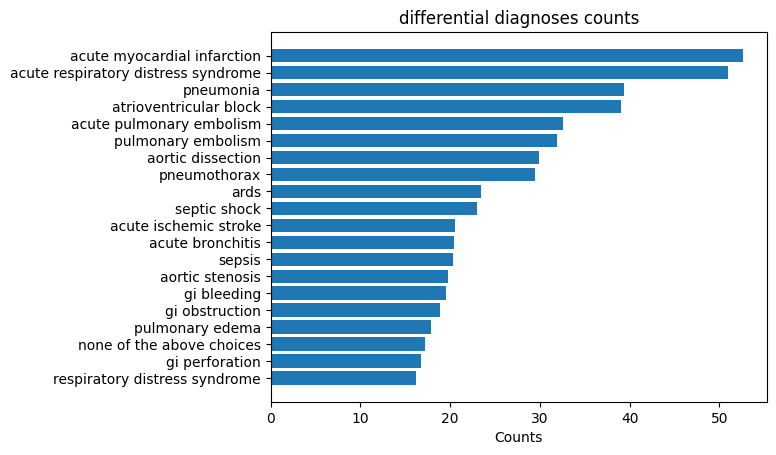

risk prediction
[('pulmonary embolism', 1245), ('cardiac arrest', 1149), ('pneumonia', 1087), ('heart disease', 1067), ('heart failure', 866), ('aortic dissection', 798), ('pneumothorax', 704), ('atelectasis', 679), ('arrhythmia', 651), ('aortic stenosis', 644), ('coma', 589), ('pleural effusion', 581), ('acute respiratory distress syndrome', 547), ('bronchitis', 542), ('ards', 536), ('pulmonary edema', 530), ('myocardial infarction', 511), ('heart attack', 509), ('sepsis', 502), ('pulmonary hypertension', 502)]


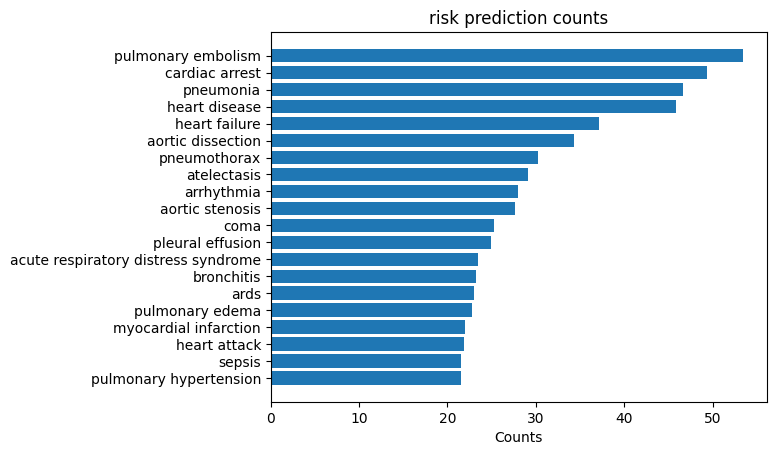

presenting complaint
[('chest pain', 199), ('respiratory distress', 195), ('shortness of breath', 178), ('abdominal pain', 124), ('', 115), ('fever', 105), ('dyspnea', 69), ('headache', 69), ('respiratory failure', 67), ('altered mental status', 58), ('back pain', 54), ('sob', 52), ('gi bleed', 50), ('potential sepsis', 47), ('hypotension', 46), ('cough', 44), ('tachycardia', 35), ('hypoxia', 35), ('s p fall', 34), ('pneumonia', 31)]


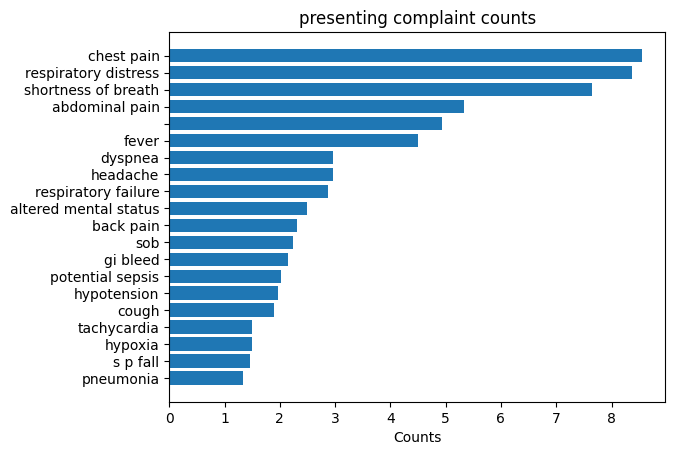

differentials from complaint
[('pulmonary embolism', 422), ('bronchitis', 298), ('heart attack', 294), ('thromboembolic stroke', 269), ('gi bleeding', 249), ('tuberculosis', 220), ('emphysema', 213), ('pulmonary edema', 184), ('heart failure', 173), ('stroke', 172), ('heart disease', 172), ('pulmonary fibrosis', 169), ('alzheimer s disease', 162), ('acute respiratory distress syndrome ards', 158), ('pneumonia', 149), ('acute respiratory distress syndrome', 148), ('cardiac arrest', 147), ('thrombocytopenia', 147), ('tuberculosis pneumonia', 134), ('pulmonary hypertension', 131)]


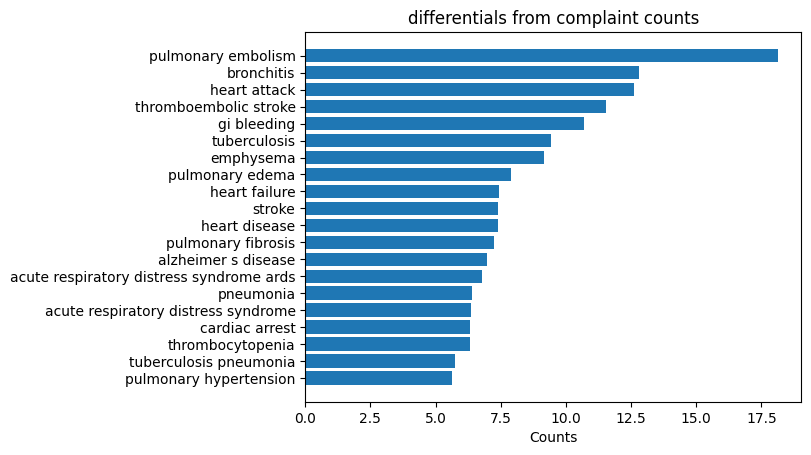

confident diagnoses
[('atelectasis', 427), ('pleural effusion', 352), ('aortic dissection', 323), ('atrial fibrillation', 278), ('pulmonary edema', 276), ('pneumonia', 276), ('aortic stenosis', 257), ('acute respiratory distress syndrome', 237), ('pneumothorax', 216), ('coronary artery disease', 189), ('left ventricular hypertrophy', 168), ('aortic valve disease', 153), ('pleural effusions', 152), ('pulmonary embolism', 151), ('acute myocardial infarction', 129), ('bacterial', 127), ('dvt', 121), ('congestive heart failure', 119), ('sepsis', 116), ('heart failure', 110)]


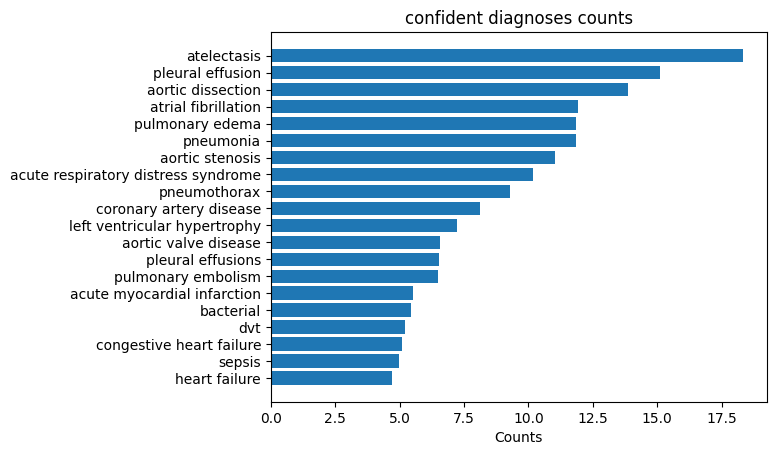

matched confident diagnoses
[('aortic dissection', 325), ('pneumonia', 281), ('atrial fibrillation', 279), ('aortic stenosis.', 259), ('pneumothorax', 232), ('coronary artery disease', 189), ('pulmonary embolism', 178), ('aortic valve disease.', 161), ('heart failure', 160), ('acute myocardial infarction', 136), ('sepsis', 129), ('congestive heart failure', 123), ('sinus tachycardia', 112), ('pulmonary hypertension', 112), ('aortic valve stenosis', 108), ('primary pulmonary fibrosis', 105), ('cardiomegaly', 104), ('deep vein thrombosis', 101), ('bronchitis', 92), ('mitral valve regurgitation', 90)]


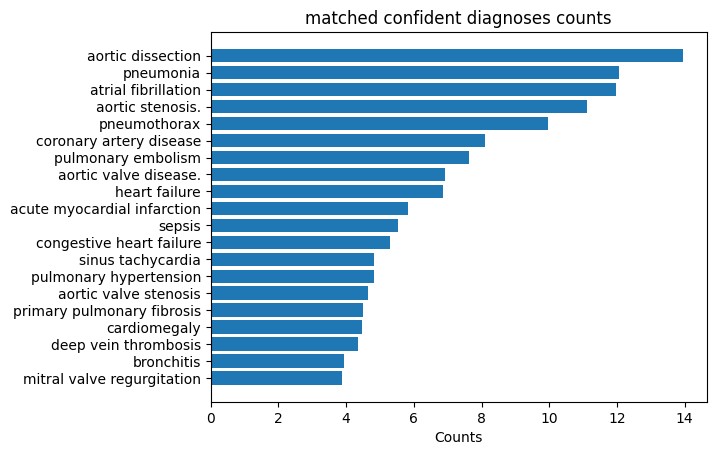

In [23]:

plot_counts(cache_info, get_counts(cache_info))

differential diagnoses
[('acute ischemic stroke', 42), ('stroke', 38), ('acute myocardial infarction', 36), ('pneumonia', 34), ('atrioventricular block', 30), ('acute respiratory distress syndrome', 28), ('acute pulmonary embolism', 26), ('aortic dissection', 25), ('acute stroke', 25), ('head trauma', 24), ('headache', 21), ('hemorrhage', 17), ('encephalitis', 17), ('acute intracranial hemorrhage', 16), ('pulmonary embolism', 15), ('ich', 15), ('septic shock', 15), ('none of the above choices', 15), ('ards', 14), ('brain tumor', 14)]


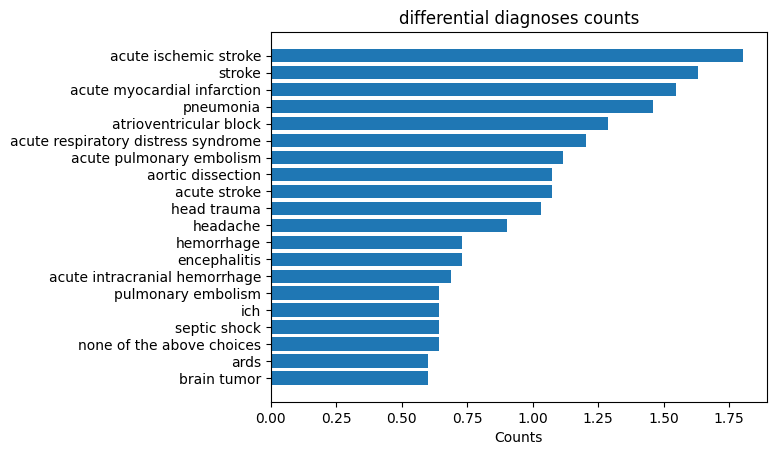

risk prediction
[('heart disease', 41), ('stroke', 40), ('pulmonary embolism', 39), ('cardiac arrest', 37), ('headache', 36), ('hemorrhage', 35), ('pneumonia', 35), ('head trauma', 32), ('coma', 29), ('aortic dissection', 26), ('atelectasis', 25), ('heart failure', 24), ('pneumothorax', 23), ('pulmonary edema', 19), ('ards', 17), ('bronchitis', 17), ('hematoma', 17), ('heart attack', 16), ('acute respiratory distress syndrome', 16), ('aspiration pneumonia', 15)]


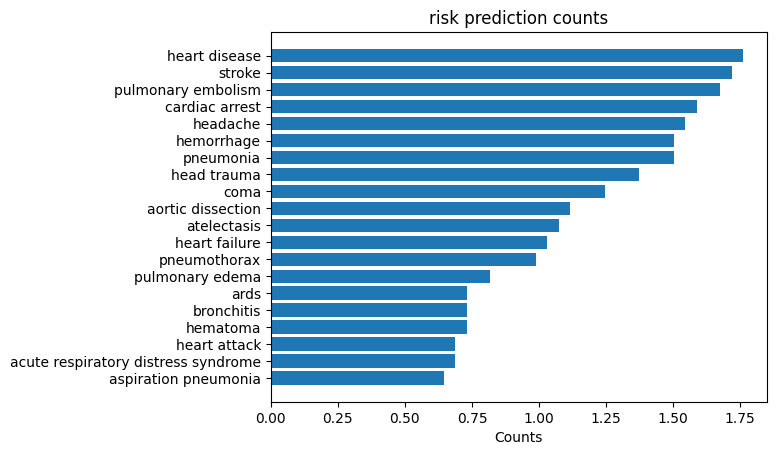

presenting complaint
[('headache', 69), ('', 10), ('ha', 8), ('sah', 7), ('head trauma', 7), ('chest pain', 6), ('shortness of breath', 5), ('headaches', 4), ('s p fall', 4), ('ich', 4), ('hematuria', 3), ('seizure', 3), ('fall', 3), ('syncope', 3), ('altered mental status', 3), ('severe headache', 3), ('fever', 3), ('intracranial hemorrhage', 3), ('s p mvc', 3), ('seizures', 3)]


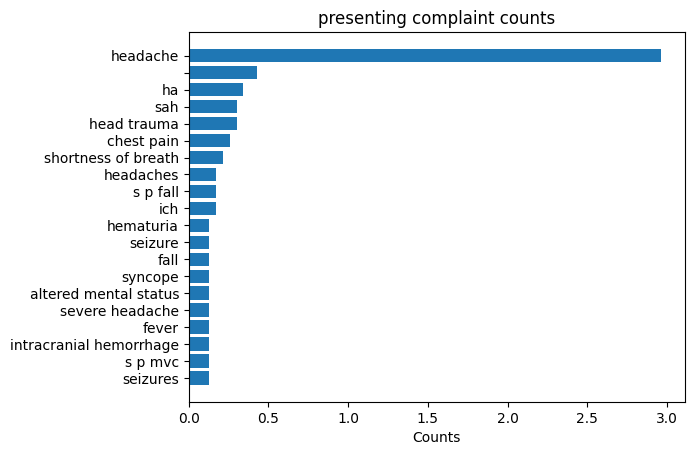

differentials from complaint
[('migraine', 65), ('thromboembolic stroke', 19), ('stroke', 17), ('alzheimer s disease', 15), ('pulmonary embolism', 15), ('headache', 13), ('ha', 11), ('thrombocytopenia', 11), ('cardiac arrest', 9), ('heart attack', 9), ('tuberculosis', 9), ('spondylolisthesis', 7), ('head injury', 7), ('traumatic brain injury', 7), ('epilepsy', 6), ('psychiatric disorders', 5), ('als', 5), ('acute inflammatory demyelinating polyneuropathy', 5), ('arthritis', 5), ('head trauma', 5)]


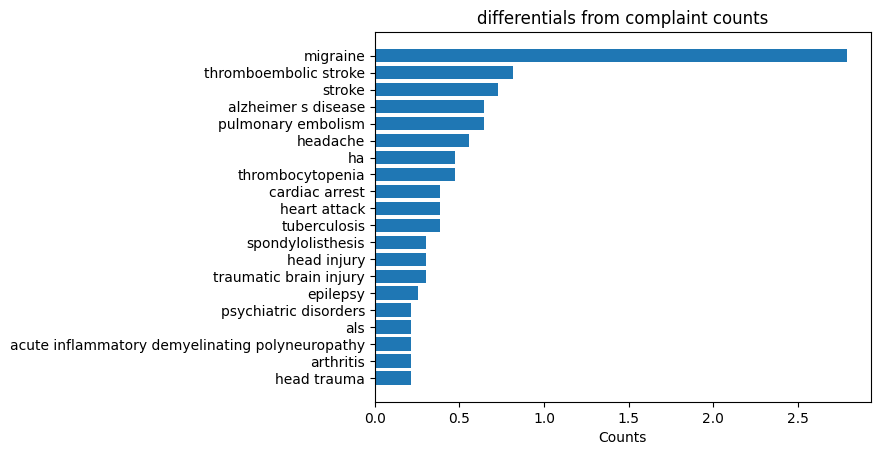

confident diagnoses
[('ischemic stroke', 17), ('subarachnoid hemorrhage', 17), ('hemorrhage', 12), ('hematoma', 11), ('pneumonia', 11), ('aortic dissection', 11), ('subdural hematoma', 11), ('pleural effusion', 10), ('head trauma', 10), ('atelectasis', 9), ('bleed', 8), ('brain', 8), ('pulmonary edema', 7), ('acute subarachnoid hemorrhage', 7), ('sah', 7), ('acute stroke', 7), ('fracture', 6), ('left ventricular hypertrophy', 6), ('aneurysm', 6), ('intracranial hemorrhage', 6)]


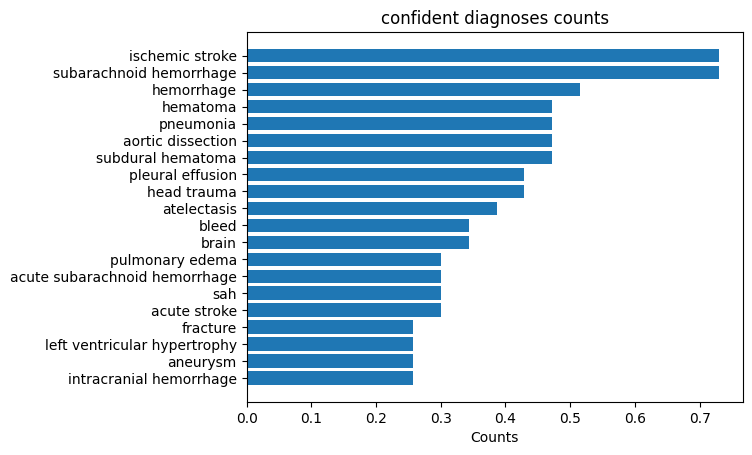

matched confident diagnoses
[('subarachnoid hemorrhage', 22), ('pneumonia', 11), ('aortic dissection', 11), ('acute stroke', 7), ('heart failure', 6), ('deep vein thrombosis', 6), ('aneurysm', 6), ('pulmonary embolism', 5), ('pneumothorax', 5), ('brain tumor', 5), ('aortic aneurysm', 4), ('acute myocardial infarction', 4), ('atrial fibrillation', 4), ('aortic stenosis.', 3), ('intracerebral hemorrhage', 3), ('hypertension', 3), ('epilepsy', 3), ('aortic valve stenosis', 3), ('mitral valve regurgitation', 3), ('bronchitis', 3)]


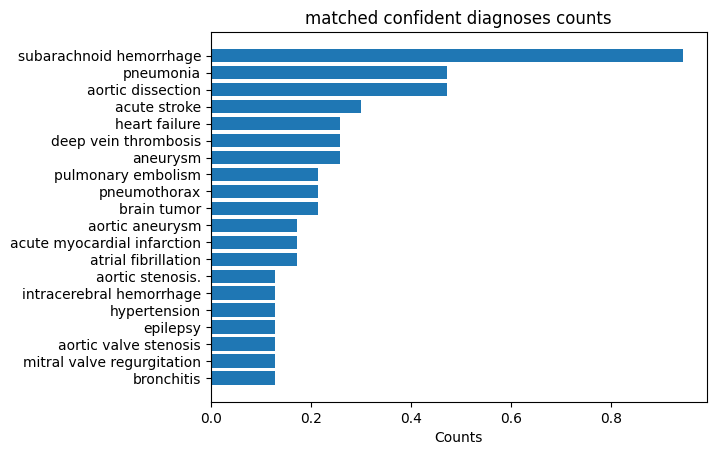

In [24]:

plot_counts(cache_info, get_counts(cache_info[cache_info['presenting complaint'].apply(lambda x: 'headache' in x)]))